# Modeling - First Pass

### Installs, Packages, Seeds

In [1]:
tdf

NameError: name 'tdf' is not defined

In [1]:
# %pip install efficientnet_pytorch

In [2]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# other
import importlib

In [4]:
# import build_model
# importlib.reload(build_model)

# from build_model import initialize_model, load_split_data, build_loader, evaluate, train_model

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Parameters

In [5]:
model_dict = {'pretrained_model': 'resnet',
              'epochs': 3,
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .002,
              'batch_size':64,
              'num_workers':24,
              'transform_set':'a',
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


## Data

In [6]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

## Modeling

In [7]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                        num_classes = len(data.label.unique()),
                                        feature_extract = False, 
                                        use_pretrained=True)

# Define GPU:
device = torch.device('cuda:0')

# Move model to GPU
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

After model is defined, add final Parameters

In [8]:
# add some params after model definition
model_dict.update({'model':model,
                   'device':device,
                   'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr']),
                   'criterion': nn.CrossEntropyLoss().to(device),
                   'tuned_model_name':'resnet_split3_3e_Ta',})

In [9]:
transform_header = [
                  transforms.Resize(255),
                  transforms.CenterCrop(224)]

transform_body = [
                  transforms.RandomHorizontalFlip(), # a
                  transforms.RandomVerticalFlip(), # b
                  transforms.RandomRotation(20), # c
                  transforms.RandomCrop(size=(input_size,input_size)), # d
                  transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
                  transforms.RandomAdjustSharpness(sharpness_factor=2), # f
                  transforms.RandomSolarize(threshold=192.0), # g
                  transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                  ]

transform_footer = [transforms.ToTensor(), 
                  transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]

In [10]:
# transform_list = transform_header + transform_body + transform_footer

In [11]:
# using torch vision 'transforms'
# train_transform = transforms.Compose(transform_list)
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                      transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

In [12]:
# tdf['transform'][0]

In [13]:
trans = [0, 1, 2, 3, 4, 5, 6, 7]
lrs = [.001, .0015, .002, .0025, .003, .0035, .004]
prods = list(product(trans, lrs))

trans_num = pd.Series(list(zip(*prods))[0], name = 'transform', dtype = 'int')
learn_rate = pd.Series(list(zip(*prods))[1], name = 'lr')
tdf = pd.concat([trans_num, learn_rate], axis = 1)
tdf['accur'] = pd.Series(dtype = 'float')
tdf['accur_0'] = pd.Series(dtype = 'float')
tdf['accur_1'] = pd.Series(dtype = 'float')
tdf['accur_2'] = pd.Series(dtype = 'float')
tdf['accur_3'] = pd.Series(dtype = 'float')
tdf['accur_4'] = pd.Series(dtype = 'float')
tdf['accur_5'] = pd.Series(dtype = 'float')

### Assemble data loaders

Run the model

In [14]:
HOME = model_dict['home_directory']

In [15]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Train Sequence

In [24]:
model_dict['epochs'] = 3


Starting Training resnet_split3_3e_GS0
[epoch 1], [iter 100 of 211],[train loss 0.04669], [train acc 0.99000]
[epoch 1], [iter 200 of 211],[train loss 0.04722], [train acc 0.99031]
------------------------------------------------------------
[epoch 1], [val loss 1.19721], [val acc 0.70627]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 26s
best record: [epoch 1], [val loss 1.19721], [val acc 0.70627]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.03915], [train acc 0.99266]
[epoch 2], [iter 200 of 211],[train loss 0.03828], [train acc 0.99344]
------------------------------------------------------------
[epoch 2], [val loss 1.20327], [val acc 0.70264]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 28s
best record: [epoch 2], [val loss 1.20327], [val ac

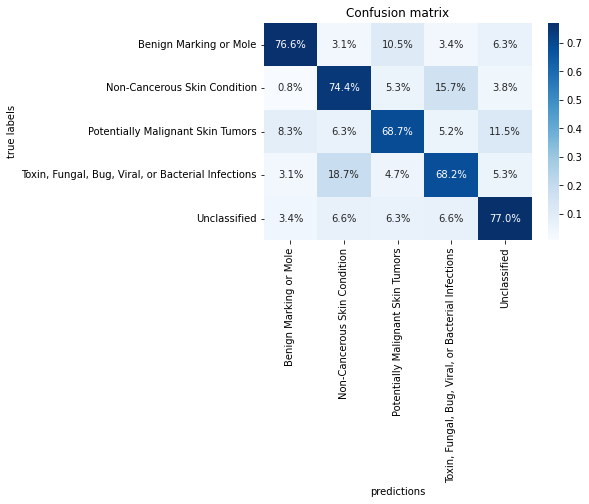

Empty DataFrame
Columns: [transform, lr, accur]
Index: []
Starting Training resnet_split3_3e_GS1
[epoch 1], [iter 100 of 211],[train loss 0.02991], [train acc 0.99609]
[epoch 1], [iter 200 of 211],[train loss 0.03159], [train acc 0.99539]
------------------------------------------------------------
[epoch 1], [val loss 1.24749], [val acc 0.69901]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 31s
best record: [epoch 1], [val loss 1.24749], [val acc 0.69901]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.02932], [train acc 0.99500]
[epoch 2], [iter 200 of 211],[train loss 0.03059], [train acc 0.99500]
------------------------------------------------------------
[epoch 2], [val loss 1.22652], [val acc 0.70422]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 

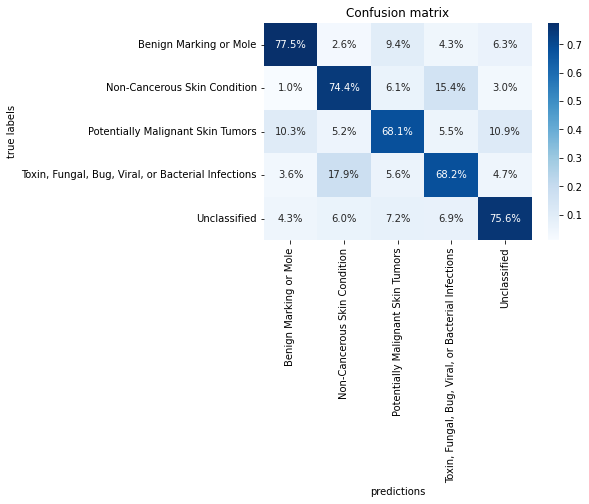

   transform     lr  accur
0          0  0.001   0.73
Starting Training resnet_split3_3e_GS2
[epoch 1], [iter 100 of 211],[train loss 0.01920], [train acc 0.99750]
[epoch 1], [iter 200 of 211],[train loss 0.02007], [train acc 0.99734]
------------------------------------------------------------
[epoch 1], [val loss 1.25015], [val acc 0.70300]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 29s
best record: [epoch 1], [val loss 1.25015], [val acc 0.70300]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.02070], [train acc 0.99844]
[epoch 2], [iter 200 of 211],[train loss 0.02214], [train acc 0.99695]
------------------------------------------------------------
[epoch 2], [val loss 1.28355], [val acc 0.70264]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 3

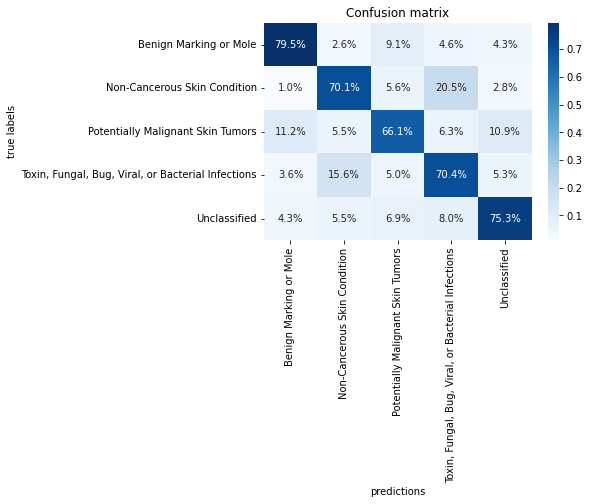

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
Starting Training resnet_split3_3e_GS3
[epoch 1], [iter 100 of 211],[train loss 0.01862], [train acc 0.99687]
[epoch 1], [iter 200 of 211],[train loss 0.01880], [train acc 0.99711]
------------------------------------------------------------
[epoch 1], [val loss 1.28702], [val acc 0.70494]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 29s
best record: [epoch 1], [val loss 1.28702], [val acc 0.70494]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01919], [train acc 0.99781]
[epoch 2], [iter 200 of 211],[train loss 0.01791], [train acc 0.99781]
------------------------------------------------------------
[epoch 2], [val loss 1.28091], [val acc 0.71306]
------------------------------------------------------------

EPOCH 2 :
*******************************

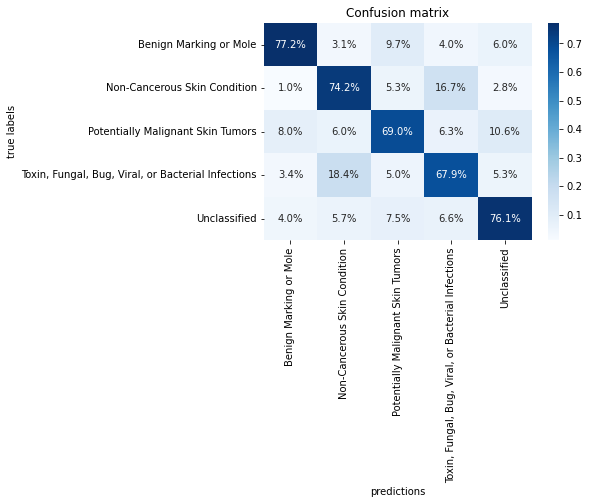

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
Starting Training resnet_split3_3e_GS4
[epoch 1], [iter 100 of 211],[train loss 0.01571], [train acc 0.99828]
[epoch 1], [iter 200 of 211],[train loss 0.01597], [train acc 0.99805]
------------------------------------------------------------
[epoch 1], [val loss 1.32684], [val acc 0.70531]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 30s
best record: [epoch 1], [val loss 1.32684], [val acc 0.70531]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01199], [train acc 0.99875]
[epoch 2], [iter 200 of 211],[train loss 0.01430], [train acc 0.99820]
------------------------------------------------------------
[epoch 2], [val loss 1.33106], [val acc 0.70482]
------------------------------------------------------------

EPOCH 2 :


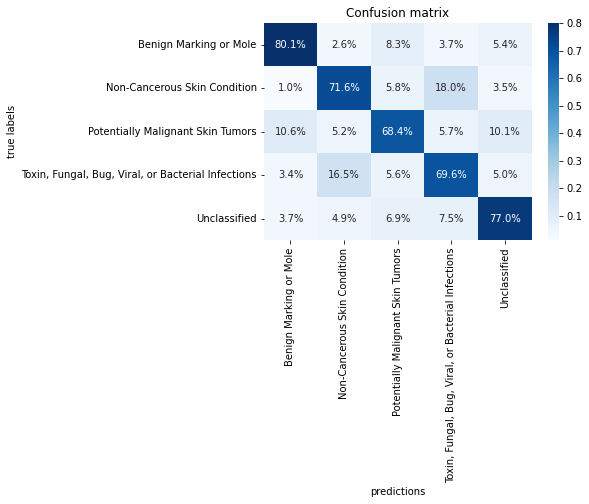

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
Starting Training resnet_split3_3e_GS5
[epoch 1], [iter 100 of 211],[train loss 0.01196], [train acc 0.99828]
[epoch 1], [iter 200 of 211],[train loss 0.01205], [train acc 0.99820]
------------------------------------------------------------
[epoch 1], [val loss 1.32856], [val acc 0.71172]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 28s
best record: [epoch 1], [val loss 1.32856], [val acc 0.71172]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01157], [train acc 0.99813]
[epoch 2], [iter 200 of 211],[train loss 0.01131], [train acc 0.99852]
------------------------------------------------------------
[epoch 2], [val loss 1.32503], [val acc 0.70446]
-----------------------------------------

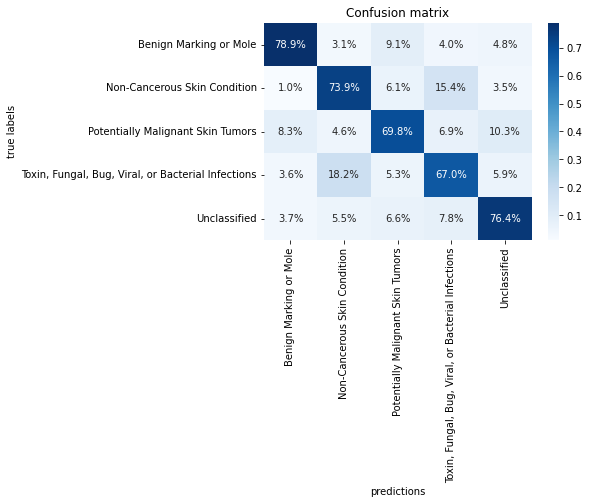

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
Starting Training resnet_split3_3e_GS6
[epoch 1], [iter 100 of 211],[train loss 0.01106], [train acc 0.99875]
[epoch 1], [iter 200 of 211],[train loss 0.01162], [train acc 0.99844]
------------------------------------------------------------
[epoch 1], [val loss 1.33384], [val acc 0.70749]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 26s
best record: [epoch 1], [val loss 1.33384], [val acc 0.70749]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01165], [train acc 0.99828]
[epoch 2], [iter 200 of 211],[train loss 0.01112], [train acc 0.99844]
------------------------------------------------------------
[epoch 2], [val loss 1.36509], [val acc 0.71039]
----------

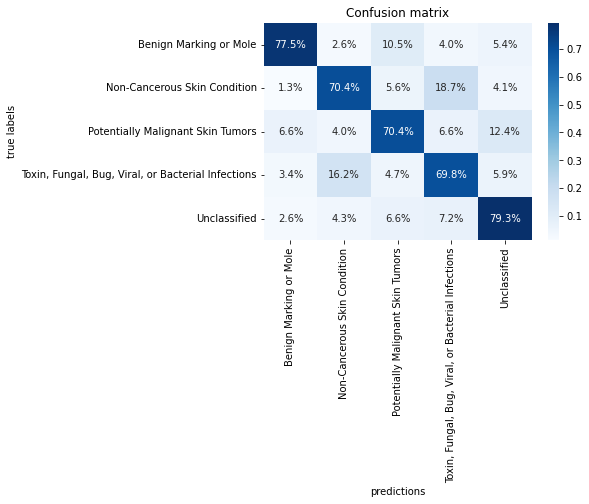

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
5          0  0.0035  0.732222
Starting Training resnet_split3_3e_GS7
[epoch 1], [iter 100 of 211],[train loss 0.06308], [train acc 0.98047]
[epoch 1], [iter 200 of 211],[train loss 0.06245], [train acc 0.98016]
------------------------------------------------------------
[epoch 1], [val loss 1.41267], [val acc 0.70094]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 31s
best record: [epoch 1], [val loss 1.41267], [val acc 0.70094]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.04800], [train acc 0.98609]
[epoch 2], [iter 200 of 211],[train loss 0.05078], [train acc 0.98484]
------------------------------------------------------------
[epoch 2], [val loss 1.37601

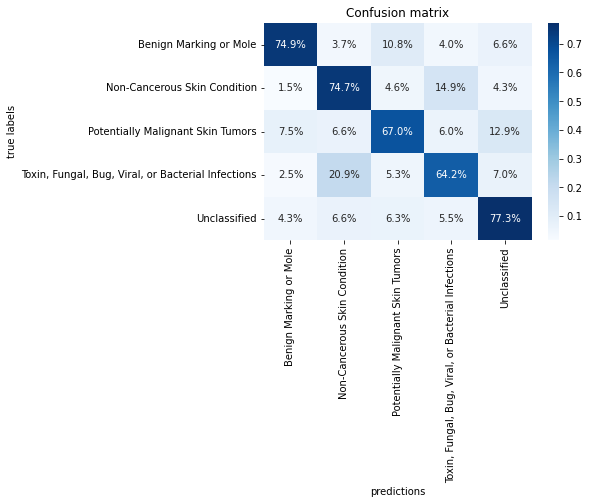

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
5          0  0.0035  0.732222
6          0  0.0040  0.733889
Starting Training resnet_split3_3e_GS8
[epoch 1], [iter 100 of 211],[train loss 0.02841], [train acc 0.99406]
[epoch 1], [iter 200 of 211],[train loss 0.02759], [train acc 0.99438]
------------------------------------------------------------
[epoch 1], [val loss 1.35732], [val acc 0.71148]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 29s
best record: [epoch 1], [val loss 1.35732], [val acc 0.71148]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.03258], [train acc 0.99125]
[epoch 2], [iter 200 of 211],[train loss 0.03254], [train acc 0.99156]
----------------------------------------------------------

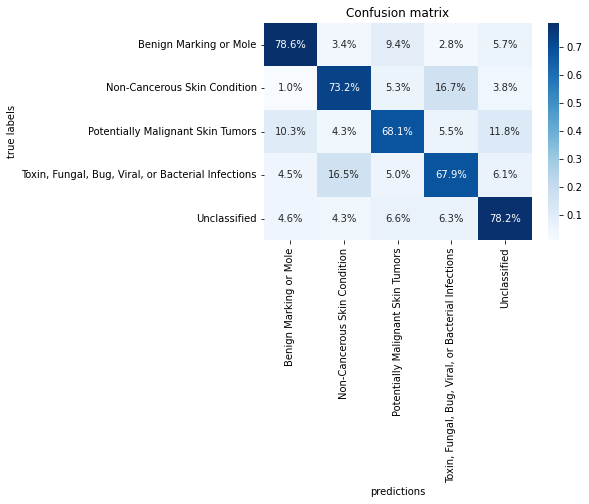

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
5          0  0.0035  0.732222
6          0  0.0040  0.733889
7          1  0.0010  0.716667
Starting Training resnet_split3_3e_GS9
[epoch 1], [iter 100 of 211],[train loss 0.01938], [train acc 0.99750]
[epoch 1], [iter 200 of 211],[train loss 0.02288], [train acc 0.99586]
------------------------------------------------------------
[epoch 1], [val loss 1.39077], [val acc 0.71221]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 23s
best record: [epoch 1], [val loss 1.39077], [val acc 0.71221]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01766], [train acc 0.99672]
[epoch 2], [iter 200 of 211],[train loss 0.01701], [train acc 0.99680]
---------------------------

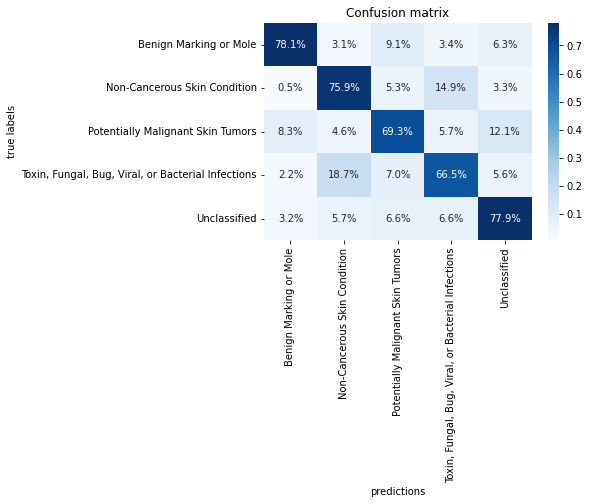

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
5          0  0.0035  0.732222
6          0  0.0040  0.733889
7          1  0.0010  0.716667
8          1  0.0015  0.731667
Starting Training resnet_split3_3e_GS10
[epoch 1], [iter 100 of 211],[train loss 0.01743], [train acc 0.99656]
[epoch 1], [iter 200 of 211],[train loss 0.01723], [train acc 0.99727]
------------------------------------------------------------
[epoch 1], [val loss 1.40669], [val acc 0.70010]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 33s
best record: [epoch 1], [val loss 1.40669], [val acc 0.70010]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01314], [train acc 0.99813]
[epoch 2], [iter 200 of 211],[train loss 0.01412], [train acc 0.99

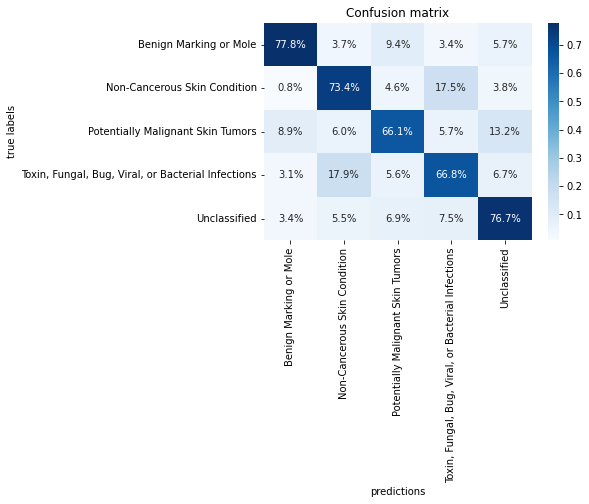

   transform      lr     accur
0          0  0.0010  0.730000
1          0  0.0015  0.727778
2          0  0.0020  0.722222
3          0  0.0025  0.728889
4          0  0.0030  0.732778
5          0  0.0035  0.732222
6          0  0.0040  0.733889
7          1  0.0010  0.716667
8          1  0.0015  0.731667
9          1  0.0020  0.735556
Starting Training resnet_split3_3e_GS11
[epoch 1], [iter 100 of 211],[train loss 0.01076], [train acc 0.99891]
[epoch 1], [iter 200 of 211],[train loss 0.01295], [train acc 0.99789]
------------------------------------------------------------
[epoch 1], [val loss 1.40876], [val acc 0.70312]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 23s
best record: [epoch 1], [val loss 1.40876], [val acc 0.70312]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01197], [train acc 0.99750]
[epoch 2], [iter 200 of 211],[train

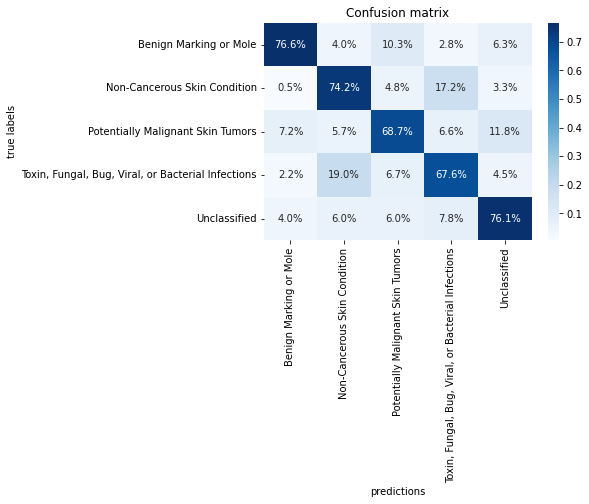

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
Starting Training resnet_split3_3e_GS12
[epoch 1], [iter 100 of 211],[train loss 0.01079], [train acc 0.99906]
[epoch 1], [iter 200 of 211],[train loss 0.01006], [train acc 0.99891]
------------------------------------------------------------
[epoch 1], [val loss 1.45494], [val acc 0.70591]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 33s
best record: [epoch 1], [val loss 1.45494], [val acc 0.70591]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 0.01345], [train acc 0

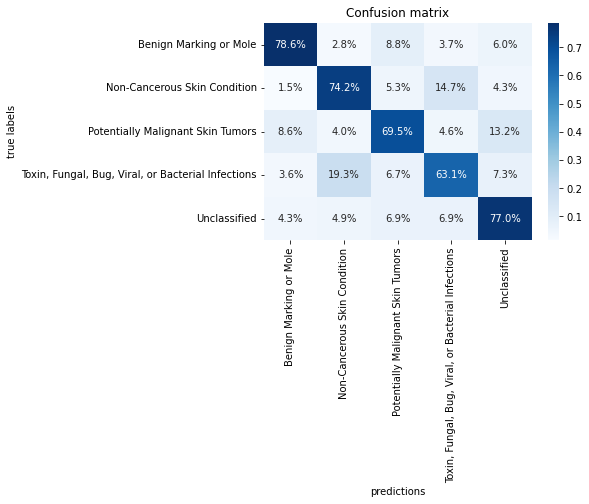

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
Starting Training resnet_split3_3e_GS13
[epoch 1], [iter 100 of 211],[train loss 0.00836], [train acc 0.99891]
[epoch 1], [iter 200 of 211],[train loss 0.00863], [train acc 0.99859]
------------------------------------------------------------
[epoch 1], [val loss 1.42357], [val acc 0.71063]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 19s
best record: [epoch 1], [val loss 1.42357], [val acc 0.71063]
*****************************************************
[epoch 2], [iter 100 of 211],[t

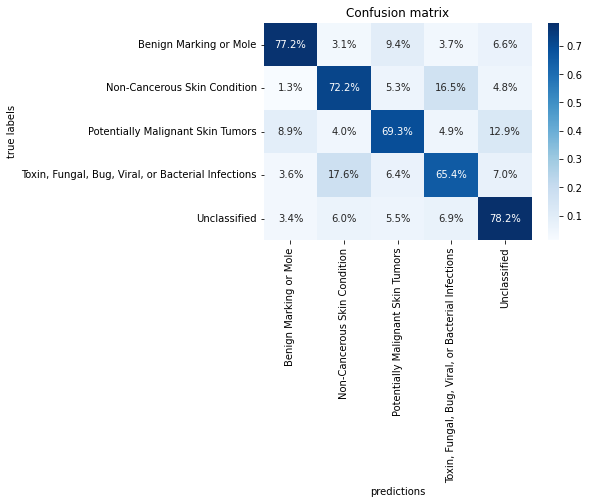

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
Starting Training resnet_split3_3e_GS14
[epoch 1], [iter 100 of 211],[train loss 0.70436], [train acc 0.78844]
[epoch 1], [iter 200 of 211],[train loss 0.62822], [train acc 0.80227]
------------------------------------------------------------
[epoch 1], [val loss 1.30995], [val acc 0.68205]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 32s
best record: [epoch 1], [val loss 1.30995], [val acc 0.68205]
*****************************************************

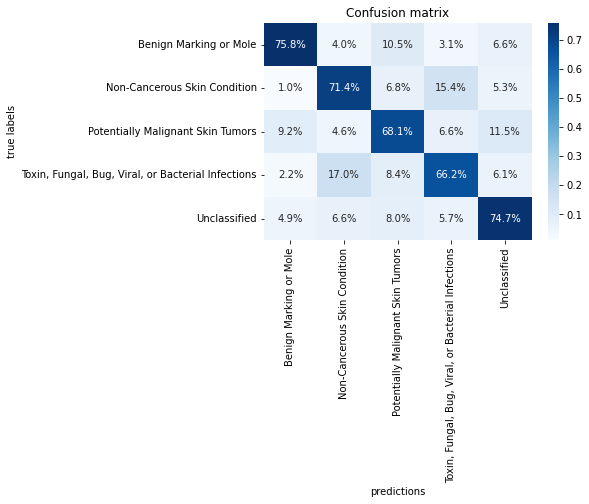

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
Starting Training resnet_split3_3e_GS15
[epoch 1], [iter 100 of 211],[train loss 0.24035], [train acc 0.91469]
[epoch 1], [iter 200 of 211],[train loss 0.25210], [train acc 0.90891]
------------------------------------------------------------
[epoch 1], [val loss 1.15439], [val acc 0.70409]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 30s
best record: [epoch 1], [val loss 1.15439], [val acc 0.70409]
*********************

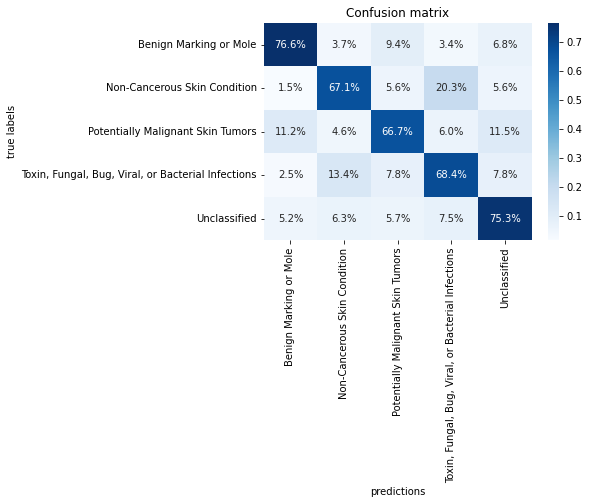

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
Starting Training resnet_split3_3e_GS16
[epoch 1], [iter 100 of 211],[train loss 0.15450], [train acc 0.94797]
[epoch 1], [iter 200 of 211],[train loss 0.16025], [train acc 0.94523]
------------------------------------------------------------
[epoch 1], [val loss 1.16589], [val acc 0.70518]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 31s
best record: [epoch 1], [val loss 1.16589], [val ac

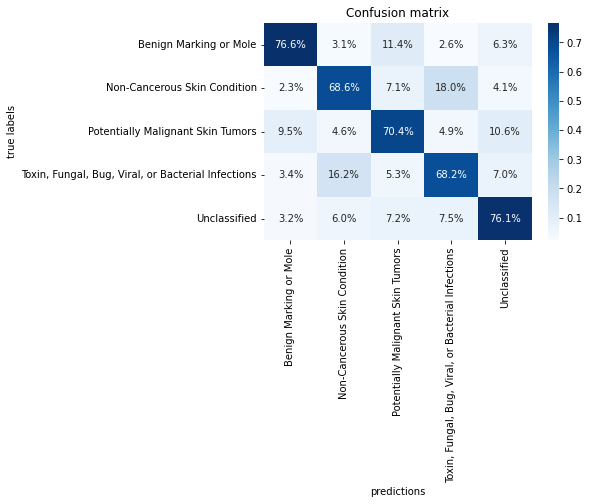

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
Starting Training resnet_split3_3e_GS17
[epoch 1], [iter 100 of 211],[train loss 0.11161], [train acc 0.96125]
[epoch 1], [iter 200 of 211],[train loss 0.11355], [train acc 0.96109]
------------------------------------------------------------
[epoch 1], [val loss 1.21972], [val acc 0.70894]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 31s
best record: [epoch

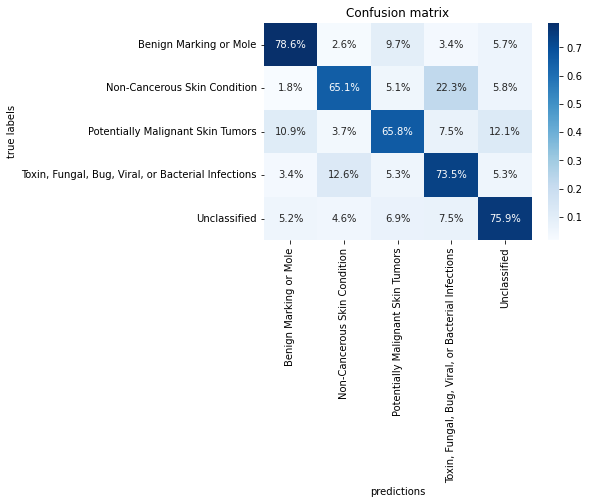

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
Starting Training resnet_split3_3e_GS18
[epoch 1], [iter 100 of 211],[train loss 0.08139], [train acc 0.97234]
[epoch 1], [iter 200 of 211],[train loss 0.08471], [train acc 0.97125]
------------------------------------------------------------
[epoch 1], [val loss 1.25256], [val acc 0.72238]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Comple

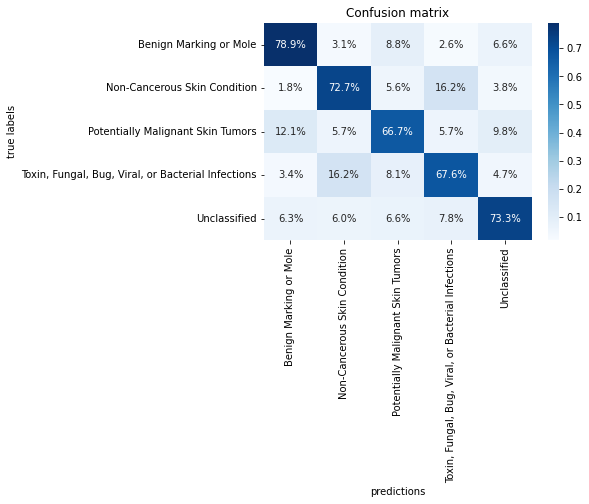

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
Starting Training resnet_split3_3e_GS19
[epoch 1], [iter 100 of 211],[train loss 0.06623], [train acc 0.97813]
[epoch 1], [iter 200 of 211],[train loss 0.06489], [train acc 0.97992]
------------------------------------------------------------
[epoch 1], [val loss 1.27734], [val acc 0.72166]
------------------------------------------------------------

EPOCH 1 :
****************************

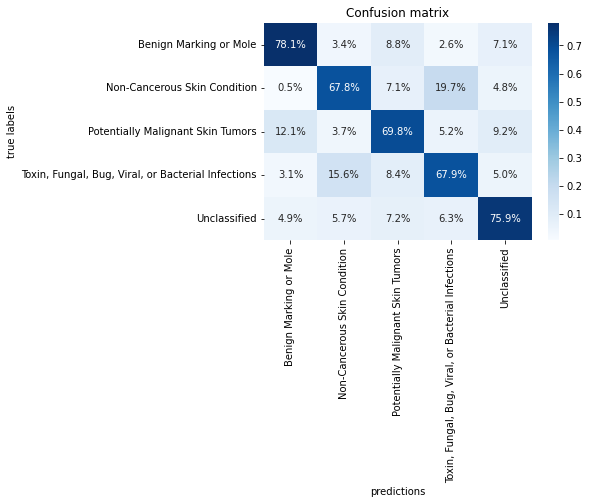

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
Starting Training resnet_split3_3e_GS20
[epoch 1], [iter 100 of 211],[train loss 0.05054], [train acc 0.98531]
[epoch 1], [iter 200 of 211],[train loss 0.05197], [train acc 0.98391]
------------------------------------------------------------
[epoch 1], [val loss 1.27653], [val acc 0.72614]
------------------------------------------------------------

EPOCH 

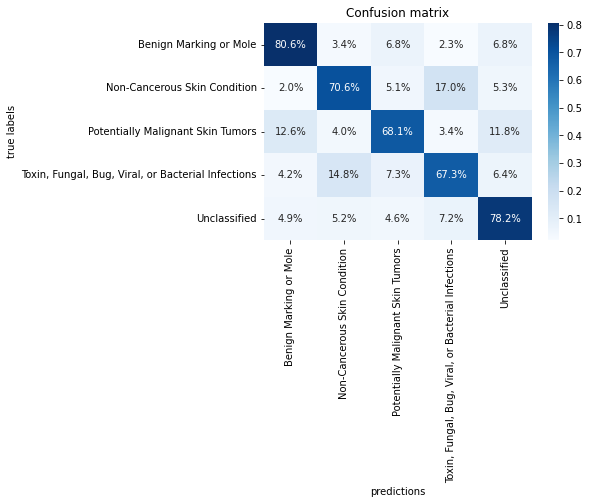

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
19          2  0.0035  0.717778
Starting Training resnet_split3_3e_GS21
[epoch 1], [iter 100 of 211],[train loss 0.02620], [train acc 0.99219]
[epoch 1], [iter 200 of 211],[train loss 0.02139], [train acc 0.99406]
------------------------------------------------------------
[epoch 1], [val loss 1.30051], [val acc 0.72444]
------------------------------------

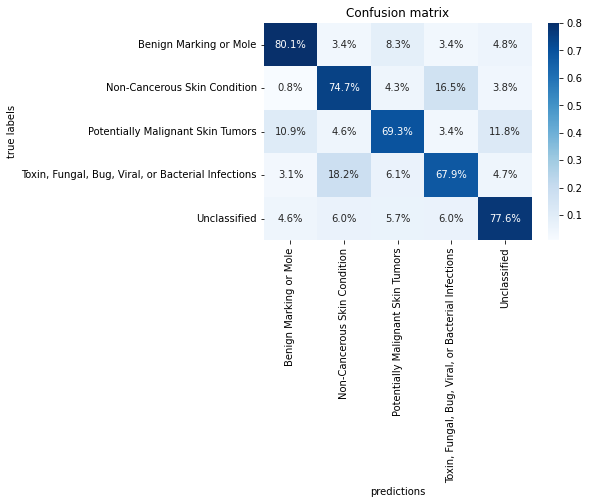

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
19          2  0.0035  0.717778
20          2  0.0040  0.728889
Starting Training resnet_split3_3e_GS22
[epoch 1], [iter 100 of 211],[train loss 0.00651], [train acc 0.99906]
[epoch 1], [iter 200 of 211],[train loss 0.00751], [train acc 0.99875]
------------------------------------------------------------
[epoch 1], [val loss 1.31340], [val acc 0.72977]
----

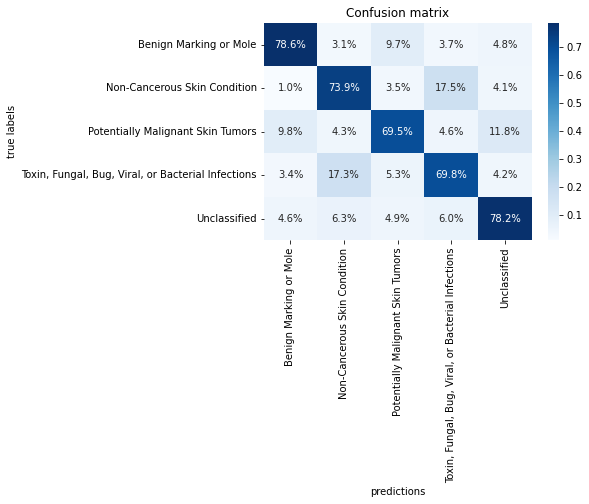

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
19          2  0.0035  0.717778
20          2  0.0040  0.728889
21          3  0.0010  0.738889
Starting Training resnet_split3_3e_GS23
[epoch 1], [iter 100 of 211],[train loss 0.00430], [train acc 0.99938]
[epoch 1], [iter 200 of 211],[train loss 0.00566], [train acc 0.99898]
------------------------------------------------------------
[epoch 1], [val loss 

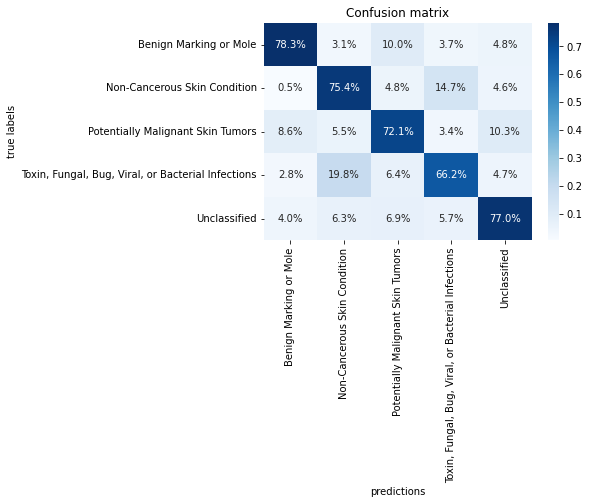

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
19          2  0.0035  0.717778
20          2  0.0040  0.728889
21          3  0.0010  0.738889
22          3  0.0015  0.740000
Starting Training resnet_split3_3e_GS24
[epoch 1], [iter 100 of 211],[train loss 0.00371], [train acc 0.99953]
[epoch 1], [iter 200 of 211],[train loss 0.00438], [train acc 0.99914]
--------------------------------------------------

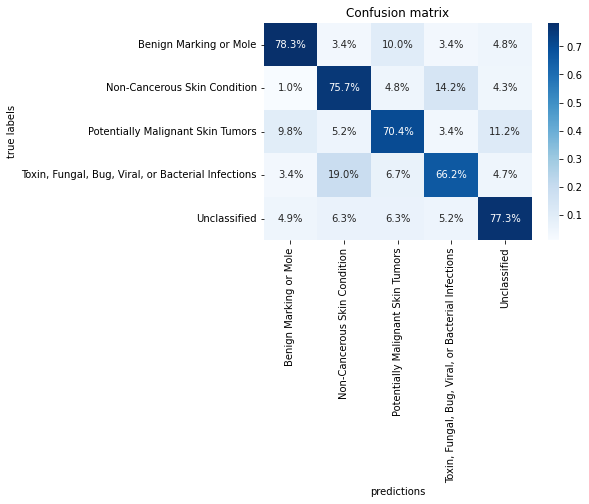

    transform      lr     accur
0           0  0.0010  0.730000
1           0  0.0015  0.727778
2           0  0.0020  0.722222
3           0  0.0025  0.728889
4           0  0.0030  0.732778
5           0  0.0035  0.732222
6           0  0.0040  0.733889
7           1  0.0010  0.716667
8           1  0.0015  0.731667
9           1  0.0020  0.735556
10          1  0.0025  0.721667
11          1  0.0030  0.726667
12          1  0.0035  0.725000
13          1  0.0040  0.723889
14          2  0.0010  0.712222
15          2  0.0015  0.707222
16          2  0.0020  0.718889
17          2  0.0025  0.716111
18          2  0.0030  0.718333
19          2  0.0035  0.717778
20          2  0.0040  0.728889
21          3  0.0010  0.738889
22          3  0.0015  0.740000
23          3  0.0020  0.738333
Starting Training resnet_split3_3e_GS25
[epoch 1], [iter 100 of 211],[train loss 0.00435], [train acc 0.99875]
[epoch 1], [iter 200 of 211],[train loss 0.00440], [train acc 0.99891]
------------------

In [ ]:
test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])

# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))

for i in tdf.iterrows():
    t_num = int(i[1]['transform'])
    lr = i[1]['lr']
    
    model_dict['alias'] = i[0]
    model_dict['transform'] = t_num
    model_dict['lr'] = lr
    model_dict['tuned_model_name'] = f'resnet_split3_3e_GS{i[0]}'
    
    transform_list = transform_header + [transform_body[t_num]] + transform_footer
    train_transform = transforms.Compose(transform_list)
    train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


    loaders = {'train_loader':train_loader,
                            'val_loader': val_loader,
                            'test_loader': test_loader}
    model_dict['loader'] = loaders

    train_model(model_dict = model_dict)
    
    pred_df = evaluate(model_name = f'gridsearch/resnet_split3_3e_GS{i[0]}', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)
    
    acc = len(pred_df[pred_df.lab_idx==pred_df.pred_idx])/len(pred_df)
    
    tdf.at[i[0], 'accur'] = acc
    
    direc = model_dict['mod_directory']
    nam = model_dict['tuned_model_name']
    pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')
    
    print(tdf.iloc[:i[0]][['transform', 'lr', 'accur']])

In [2]:
tdf

NameError: name 'tdf' is not defined

## Evaluate

In [ ]:
# # resnet_split3_3e
# pred_df = evaluate(model_name = 'resnet_split3_3e_2', 
#                    model_source = 'pt', 
#                    model_dict = model_dict, 
#                    label_dict = label_dict, 
#                    show_cm = False)